In this notebook we will discuss:
    
1) Cross-validation

2) Using ExtraTreesClassifier for feature selection.

### Cross-validation

Is a process to validate a model. The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

One round of cross-validation involves partitioning a sample of data into complementary subsets, performing the analysis on one subset (called the training set), and validating the analysis on the other subset (called the validation set or testing set). To reduce variability, in most methods multiple rounds of cross-validation are performed using different partitions, and the validation results are combined (e.g. averaged) over the rounds to give an estimate of the model's predictive performance.

References: https://en.wikipedia.org/wiki/Cross-validation_(statistics)#:~:text=Cross%2Dvalidation%2C%20sometimes%20called%20rotation,to%20an%20independent%20data%20set.

#### k-fold cross-validation

In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("Titanic.csv")

In [3]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Gender', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
print(df.shape)

(891, 12)


In [5]:
df["family_size"] = df["SibSp"] + df["Parch"] + 1

In [6]:
print(df["Parch"].head())
print("+++++++++++++")
print(df["SibSp"].head())

0    0
1    0
2    0
3    0
4    0
Name: Parch, dtype: int64
+++++++++++++
0    1
1    1
2    0
3    1
4    0
Name: SibSp, dtype: int64


In [7]:
print(df["family_size"].head())

0    2
1    2
2    1
3    2
4    1
Name: family_size, dtype: int64


In [8]:
print(df["Embarked"].unique())

['S' 'C' 'Q' nan]


In [9]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Gender           0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
family_size      0
dtype: int64


In [10]:
df["Age"].fillna(value=df["Age"].median(), inplace=True)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Gender           0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
family_size      0
dtype: int64

In [11]:
df["Embarked"].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [12]:
df["Embarked"].fillna(value="S", inplace=True)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Gender           0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
family_size      0
dtype: int64

In [13]:
embarked ={"S":0, "C":1, "Q":2}

In [14]:
df.Embarked = [embarked[item] for item in df.Embarked]

In [15]:
gender = {"female":1, "male":0}

In [16]:
df.Gender = [gender[item] for item in df.Gender]

In [17]:
dfx = df[["Age", "Gender", "family_size", "Embarked"]].copy(deep=True)
dfy = df[["Survived"]].copy(deep=True)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
x = scaler.fit_transform(dfx)

In [19]:
y = dfy

In [20]:
print(x.shape)
print(y.shape)

(891, 4)
(891, 1)


In [21]:
import numpy
x = numpy.array(x)
y = numpy.array(y)

In [22]:
print(x.shape, y.shape)

(891, 4) (891, 1)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

from sklearn.model_selection import RepeatedKFold
scores_test = []
model = LogisticRegression(solver='lbfgs', penalty='l2', random_state=1)
rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in rkf.split(x):
    #print("Train:", train_index, "Validation:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    #print(x_train.shape, x_test.shape)
    y_train, y_test = y[train_index], y[test_index]
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    #print(y_train.shape, y_test.shape)
    model.fit(x_train, y_train)
    ypred = model.predict(x_test)
    scores_test.append(model.score(x_test, y_test))

In [24]:
print(scores_test)

[0.8044692737430168, 0.7921348314606742, 0.7921348314606742, 0.7640449438202247, 0.797752808988764]


In [25]:
scores_test = numpy.array(scores_test)
print(numpy.mean(scores_test))

0.7901073378946708


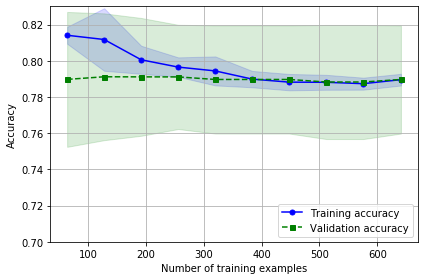

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                               X=x_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.7, 0.83])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

### Extra Tree Classifier

Extra Trees is like Random Forest, in that it builds multiple trees and splits nodes using random subsets of features, but with two key differences: it does not bootstrap observations (meaning it samples without replacement), and nodes are split on random splits, not best splits. 

In [27]:
from sklearn.ensemble import ExtraTreesClassifier 

In [28]:
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, 
                                        criterion ='entropy', max_features = 2) 
  
# Training the model 
dfy = np.array(dfy).ravel()
extra_tree_forest.fit(dfx, dfy) 
  
# Computing the importance of each feature 
feature_importance = extra_tree_forest.feature_importances_ 
  
# Normalizing the individual importances 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_], 
                                        axis = 0) 


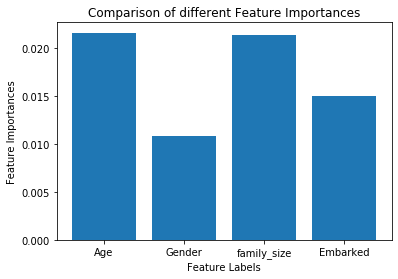

In [29]:
plt.bar(dfx.columns, feature_importance_normalized) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Comparison of different Feature Importances') 
plt.show() 